In [23]:
using PyPlot
using PyCall
using Printf
@pyimport matplotlib.animation as anim
@pyimport matplotlib.patches as patches

In [24]:
using Base64
function showanim(filename)
    base64_video = base64encode(open(filename))
    display("text/html", """<video controls src="data:video/x-m4v;base64,$base64_video">""")
end

showanim (generic function with 1 method)

In [25]:
mutable struct World
    objects
    debug
    time_span
    time_interval
    ani
end

World() = World([], false, 10, 1, nothing)
World(debug) = World([], debug, 10, 1, nothing)
World(time_span, time_interval) = World([], false, time_span, time_interval, nothing)

function append(self::World, obj)
    push!(self.objects, obj)
end

function init_draw(self::World, ax)
    ax.set_aspect("equal")
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    ax.set_xlabel("X", fontsize=20)
    ax.set_ylabel("Y", fontsize=20)
end

function draw(self::World)
    fig, ax = subplots()
    init_draw(self, ax)    
    elems = []

    if self.debug
        for i = 1:1000
            one_step(self, i, elems, ax)
        end
    else
        self.ani = anim.FuncAnimation(fig, one_step, fargs=(self, elems, ax), 
            frames = Int(self.time_span/self.time_interval)+1, interval = Int(self.time_interval*1000))
        self.ani[:save]("test.mp4", bitrate=-1, extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])
    end 
    
end

function one_step(i,self::World, elems, ax)
    plt.cla()
    init_draw(self, ax)
    while length(elems) > 0
        pop!(elems)
    end
    vcat(elems, ax.text(-4.4, 4.5, string("t = ", @sprintf("%.2f[s]", self.time_interval * i) ), fontsize=10))
    for obj in self.objects
        draw(obj, ax, elems)
        if applicable(one_step, obj, 1.0)
            one_step(obj, 1.0)
        end
    end
end

one_step (generic function with 2 methods)

In [26]:
mutable struct Agent
    nu
    omega
end
function decision(self::Agent, observation=nothing)
    return self.nu, self.omega
end

decision (generic function with 2 methods)

In [27]:
mutable struct IdealRobot
    pose
    r
    color
    agent
    poses
    sensor
end

IdealRobot(pose) = IdealRobot(pose, 0.2, "black", nothing, [pose], nothing)
IdealRobot(pose, color) = IdealRobot(pose, 0.2, color, nothing, [], nothing)
IdealRobot(pose, agent) = IdealRobot(pose, 0.2, "black", agent, [pose], nothing)
IdealRobot(pose, agent, color) = IdealRobot(pose, 0.2, color, agent, [pose], nothing)
IdealRobot(pose, agent, sensor, color) = IdealRobot(pose, 0.2, color, agent, [pose], sensor)

function draw(self::IdealRobot, ax, elems)
    x,y,theta = self.pose
    xn = x + self.r * cos(theta)
    yn = y + self.r * sin(theta)
    elems = vcat(elems, ax.plot([x, xn], [y,yn], color = self.color))
    c = patches.Circle(xy=(x,y), radius = self.r, fill = false, color = self.color)
    elems = vcat(elems, [ax.add_patch(c)])
    
    push!(self.poses, self.pose)
    elems = vcat(elems, ax.plot([e[1] for e in self.poses], [e[2] for e in self.poses], linewidth=0.5, color="black"))
    
    if !isnothing(self.sensor) && length(self.poses) > 1
        draw(self.sensor, ax, elems, self.poses[length(self.poses)-1])
    end
end

function state_transition(self::IdealRobot, nu, omega, time)
    t0 = self.pose[3]
    if abs(omega) < 1e-10
        return self.pose + [nu*cos(t0), nu*sin(t0), omega].*time
    else
        return self.pose + [nu/omega*(sin(t0+omega*time)-sin(t0)),
                                  nu/omega*(-cos(t0+omega*time)+cos(t0)),
                                 omega*time]
    end
end

function one_step(self::IdealRobot, time_interval)
    if isnothing(self.agent)
        return
    end
    obs = nothing
    if !isnothing(self.sensor)
        obs = data(self.sensor, self.pose)
    end
    nu, omega = decision(self.agent, obs)
    self.pose = state_transition(self, nu, omega, time_interval)
end

one_step (generic function with 2 methods)

In [28]:
mutable struct Landmark
    pos
    id
end

Landmark(pos) = Landmark(pos, nothing)

function draw(self::Landmark, ax, elems)
    c = ax.scatter(self.pos[1], self.pos[2], s=100, marker="*", label="landmarks", color="orange")
    elems = vcat(elems, c)
    elems = vcat(elems, ax.text( self.pos[1], self.pos[2] , string("id:", string(self.id)), fontsize=10))
end

draw (generic function with 4 methods)

In [29]:
mutable struct Map
    landmarks
end

Map() = Map([])

function append_landmark(self::Map, landmark)
    landmark.id = length(self.landmarks)
    push!(self.landmarks, landmark)
end

function draw(self::Map, ax, elems)
    for Im in self.landmarks
        draw(Im, ax, elems)
    end
end

draw (generic function with 4 methods)

In [39]:
mutable struct IdealCamera
    map::Map
    lastdata
end

IdealCamera(map) = IdealCamera(map, [])

function data(self::IdealCamera, cam_pose)
    observed = []
    for lm in self.map.landmarks
        p = observation_function(self, cam_pose, lm.pos)
        push!(observed, (p, lm.id))
    end
    self.lastdata = observed
    return observed
end

function observation_function(self::IdealCamera, cam_pose, obj_pos)
    diff = obj_pos - cam_pose[1:2]
    phi = atan(diff[2], diff[1]) - cam_pose[3]
    while phi > pi
        phi -= 2*pi
    end
    
    while phi < -pi
        phi += 2*pi
    end
    return [hypot(diff[1], diff[2]), phi]
end

function draw(self::IdealCamera, ax, elems, cam_pose)
    for lm in self.lastdata
        x,y,theta = cam_pose
        distance, direction = lm[1][1], lm[1][2]
        lx = x + distance*cos(direction + theta)
        ly = y + distance*sin(direction + theta)
        elems = vcat(elems, ax.plot([x, lx], [y,ly], color="pink"))
    end
end

draw (generic function with 5 methods)

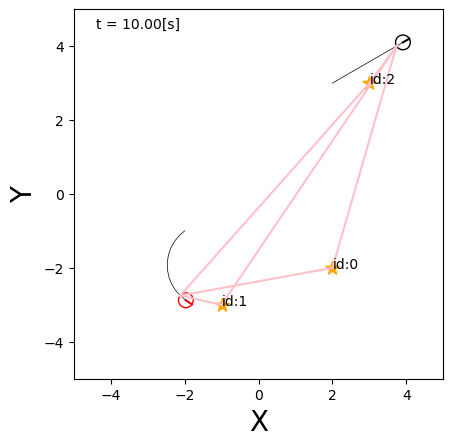

In [40]:
world = World(10, 1.0)
m = Map()
append_landmark(m, Landmark([2,-2]))
append_landmark(m, Landmark([-1,-3]))
append_landmark(m, Landmark([3,3]))
append(world, m)

straight = Agent(0.2, 0.0)
circling = Agent(0.2, 10.0/180*pi)
robot1 = IdealRobot([2, 3, pi/6], straight, IdealCamera(m),"black")
robot2 = IdealRobot([-2, -1, pi/5*6], circling, IdealCamera(m),"red")
append(world, robot1)
append(world, robot2)
draw(world)

In [41]:
showanim("test.mp4")

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAaJptZGF0AAACoAYF//+c3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1NyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMTggLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAHpNliIQAF//+99S3zLLtU2+2C6j3op4mX0N1JQGblsTtOoAAAAMAAAMAAB68FzgCX4kK868AAAMAyoAXqEn/CmOPiASefdwlV7OOckzXd26jK6wIErr1WQUBXEvp/DSgNQ97tXAs3/wekXyhX1Mb3ZVyfb/nuH7YDUTAzDzDUPcJ9aGJDYprkjIs4WNPnmhxrKfdPnMTlFUoqbrQLybesI8719ZhI5+0JZaQYm2kUPpjTShXKw7xANuR5lXGYzlr5cI6Ho17qONWYMXE42iHgk8lbYLmkoPjHUk2Oy2lQv27aY/fVfrVFt/VTdo1sv9rKj/xyPGErip3Xb/vVsxHzOfglv+DWCgJihMuLKY4P4M4YYC7KnyHUObr9v+hCqCuPX7tw73SW3wY4C90DrUzujefvIO6S7G7irYFzZbOn1biVxEjF4sN5REkcScLSevqaTzSW5zRDB24FK02n+jnMBMnxcVgYpYgTrAMidzBL2NWsRbtDDgd8oBhmta+fjKfPsnaKsFbp/rvyYGQyMUhcJk/qHDa5wO4DmztzvIew6Z7K5KkJjSQIlUFTVTDU9ILUmw+2YP70/onqA+cRwSxX3mo8WuX/LVN7XhvSD7FOrmaMgzWOzjNJETmkxq3wD58MvNJdE91o73MoXICnppwBPC06NlW57RZibsrio8FkOWCC9mgnNLdSbjBVjfDDooxFoxCBljzoZInj4QQmYAHosicxUbN7NvyucSU4a/rAbueN365dt07HLz1/8NGeaTKIPoyj6nACQd08BlrZp3GgDKHdtc7ph6dIiRfM+AMgbqdUBWHd3FBBQbWrTh61nnl8jfCrnqTkVweMp3blilOf7FvP6YdF5rkEYp6mj8ZC4QxYRwqz9IDfioh0KRjjKoYiMfuZ0RZIEX3fKZjzok8lVKi0AegBM2jEgjT1WlgYKcAvqtMpb4RajAw3LX4Fshjab9qsfwcTVVVJqDW4UXKEIqruSs0u3GyMxIxG+2bX2PId79HFBxAeMHfW4k1Qb9PntkY59hbktx6R6K99i7DQVe8d01pJkqiR5i8FQsQCtO0fC7NZW7SPb2+7JNMAKzND2koNXwOxiCLqpXmi8OeT95iRRNlPemYTMgroZmouQd/c1ccPNaOizvcUtBSymaD0rdtod8deAapQW3W/WZ9bl42rori+c6jaD2UoU5UWiIfI0m26b5gpBNa6xWFbocAfRIpjml3mkDKH8tFqxsNYtkofiH5dg+R8JHYaibLYoPdNnuAIFOQEUls6bAxOOpNWYHsStHB3ikMTyWC2AydX7N6q2JWAMoKjvG302SrJbrjh+NyN2yH22qompOgK0GiC8p20qGiiTLG+efajpudDa3N6qK7MRR/oWgpV36W/+Dpdr3di3W1lDmhgddeuXK0JwKxsK04a7byyzsrLWAGtNiJJxHUxC7j+0+4qT19mmNih7F8l8MNjTnUw9doPQ1Xv2gx1nW+5zoS3YbUcNHF2EmQOuSVObelCA2DxqoItpIKfeGha2ZZ2eaPpJD7KLvbJxTf9UIYEqaowG5f/Kz/i0p6eWR85mStBWaqrmphxpIhrlrK1/QtkrYBeDufpDbwnLYMrbIVCjuXg9Snu3cEnJeNagyvAkxB3fj4/15ar8hoSW6U/B7wm25PpK/sqaYZVrHzP5SbV176YRbyytbxXoaNiE+b400rKCv7tRzo5s9behb+AeifoknkF/n8NRjO9hlVKyCnf0B6oSvGIqmDAErgflTMu9bf9M2Puh32psf+y5HYZ29BV5clB0WfSxMcKuktEoOgr9mna/7h/5LulXF3g7nrHFX/UOy4XlFtHGUshSmdlvdoju0vbTJq6EntNX2h/utl8uVoc3Brbe6JtEEVaB3+hfyLyI/ei6QPILwrFxuHe5Rns1X4FjmH20TgB5VE+i5+Fg7Ya9HnLNsuv+ZWqQx0KHmBPJLI91A3hiJCwf2HyQnBRcyu/iOnuM+v2HTJOKQ4YAD240qpHI++j/V7ly8X8GJNjxEyL4WLZXhgewSs0hr2tiR9DuAxPuim+PLkDXSLLNIM3mNZgyK6ZhwQMa8yaMw18gdou31CZG/Rtx3UQ0sbGOh/SwHcdAelY80TqpEvRBw/wj/aMKNsnuSLCMvJ334zVcDbotAlvqareK2Yg2XhRi5QIuk94DzbHjGrVfUe8kMHZyL43FsLxi2tmJdEL9+sp8KMFrTmuCP9OXHrmitrUlTLZYwft/JZXHTDwUwbuBqlRE8ivhjlJd1ydoVx93afXnlGFjxCa1Zw2nPkjH7YO0bZzDR39ecUxqWKKFYnaLa+AhxZv59RLSmxKfFRt0KlfmjiMrIf2wAnqOr7z5Wve1cuaxIN0SQHiZYfrCrEPuyAJgl6AxOpu5LgnTcuIpYjL8PvSsSysVhzqOU9payVBTAnLlvXrhMh/sO6U4DO1MZV82Ipdb6ykpf1tn0Md8MpMsocikYoTnEUcRkS4EI75W87Udd52IBWBuFPkic5fAklzYR75pVvGcEAcqO3eGEEVvMquD7L0ACKtDjDFixmKu68uUZ6TpDlsebJuqreOdCXV0oV8XHm72FS5jGGSg3NpcljiR7ClzIP85fjBrCoXb/bqZjylZTPubRXtyOLby0oqvk12kR/xDXYZVw+Y+68H2SwE4puB9Y3EhuzOgg+0P/G3BVLW1SzokzDJb6P/GdN0KchdahcKV594VfD4fNWAppYvD/mnjL8/HMdnAsDw99SGGW9URSGySpzRtwWG1PCiBmNeuS+5l7aRDvBtEHqrkRB6hCHx42KS2tC9/+kgOY+M4a/Jxix2e1eQAvzeTVRqN3mKnQYmb8X5DvUZcd8rBqz2qmsRiqBaCarl5If2q9kqSqzL6/ckvrZn763mNeN/w9XaO7bxfEZ4cvbnZXO5F4yuSbYhYRAf3DsoqR2p0n5DOa5H/laZGoxmPjWLiknw+CfEP7u9DiLoBDbMfQLIzrGFkPFNWR